In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print('version :' , torch.__version__)
print('cuda :' , torch.cuda.is_available())
print('cudnn :' , torch.backends.cudnn.enabled)

version : 1.2.0
cuda : True
cudnn : True


In [3]:
EPOCH = 100
BATCH_SIZE = 32
LR = 0.001
DOWNLOAD_data = True

In [4]:
train_data = torchvision.datasets.CIFAR10(
    root = './data',
    train = True,
    transform=torchvision.transforms.ToTensor(), #改成torch可讀
    download=DOWNLOAD_data,
)


Files already downloaded and verified


50000
50000


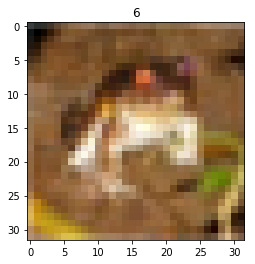

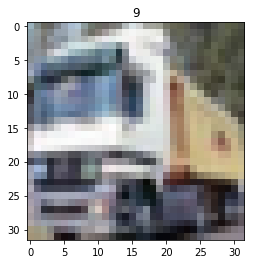

In [5]:
print(len(train_data.data))
print(len(train_data.targets))
for i in range(2):    
    img = np.asarray(train_data.data[i])
    plt.imshow(img, cmap='gray')
    plt.title('%i' % train_data.targets[i])
    plt.show()

In [6]:
test_data = torchvision.datasets.CIFAR10(root='./data/',
                              train=False,
                              transform=torchvision.transforms.ToTensor())

10000
10000


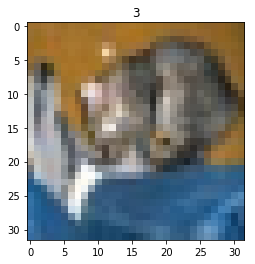

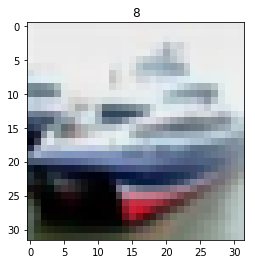

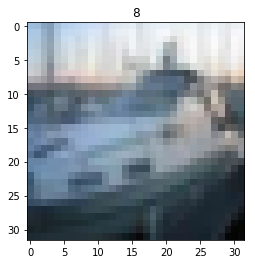

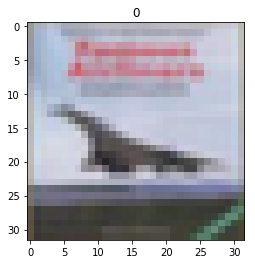

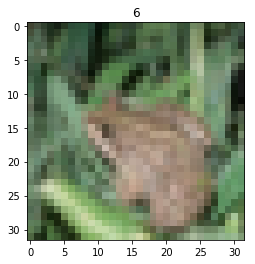

In [7]:
print(len(test_data.data))
test_data.test_data = test_data.data[:3000]
test_data.test_labels = test_data.targets[:3000]
print(len(test_data.data))
for i in range(5):    
    img = np.asarray(test_data.data[i])
    plt.imshow(img, cmap='gray')
    plt.title('%i' % test_data.targets[i])
    plt.show()

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=2,
                                          pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          num_workers=2,
                                         pin_memory=True)
print(train_loader)
print(len(train_loader))
print(test_loader)
print(len(test_loader))

1563
313


In [9]:
#test_data = torchvision.datasets.CIFAR10(root='./data/', train=False)
#print(type(test_data.test_data))

############
#i dont's know way this type was 'numpy.ndarray', so i convert it myself
#test_data.test_data = torch.unsqueeze(torch.from_numpy(test_data.test_data), dim=3)
print(type(test_data.test_data))
#print(len(test_data.test_data))
############
img,lab = train_loader.dataset[0]
print(type(lab))


<class 'numpy.ndarray'>
<class 'int'>


In [10]:
class InceptionA(nn.Module):
    def __init__(self,in_channels):
        super(InceptionA, self).__init__()
        self.conv1 = nn.Sequential(       # input  (3,_,_)
            nn.AvgPool2d(3,1,1),          # output  (3,_,_)
            nn.Conv2d(in_channels,16,1),  # output  (16,_,_)
        )
        self.conv2 = nn.Sequential(       # input  (3,_,_)
            nn.MaxPool2d(3,1,1),          # output  (3,_,_)
            nn.Conv2d(in_channels,16,1),  # output  (16,_,_)
        )
        
        self.conv3 = nn.Sequential(       # input  (3,_,_)
            nn.Conv2d(in_channels,16,1),  # output  (16,_,_)
            nn.Conv2d(16,16,5,1,2),       # output  (16,_,_)
        )
        
        self.conv4 = nn.Sequential(       # input  (3,_,_)
            nn.Conv2d(in_channels,8,1),   # output  (8,_,_)
            #nn.Conv2d(16,24,3,1,1),      # output  (24,_,_)
            nn.Conv2d(8,16,3,1,1),        # output  (16,_,_)
        )
        
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        
        outputs = [x2,x3,x4,x1]
        #outputs = [x3,x4,x1]#72
        
        return torch.cat(outputs,1)       # output  (16*4, 32, 32)<<
                                          # output  (88, 32, 32)<<
####################################################################
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(       # input  (3, 32, 32)
            nn.Conv2d(3,20,5,1,2),        # output  (20, 32, 32)
            InceptionA(in_channels=20),   # output  (64, 32, 32)
            nn.MaxPool2d(2),              # output  (64, 16, 16)
        )
        self.conv2 = nn.Sequential(       # input  (64, 16, 16)
            nn.Conv2d(64,40,5,1,2),       # output  (40, 16, 16)
            InceptionA(in_channels=40),   # output  (64, 16, 16)
            nn.MaxPool2d(2),              # output  (64, 8, 8)
        )
        
        self.out1 = nn.Linear(64*8*8, 512) #fully connected layer
        self.out2 = nn.Linear(512, 128)
        self.out3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        #x = x.view(-1, 32 * 8 * 8)
        x = x.view(x.size(0), -1)
        x = self.out1(x)
        x = self.out2(x)
        x = self.out3(x)
        #output = nn.functional.log_softmax(x, dim=1)
        return x    # return x for visualization

In [11]:
cnn = CNN()
cnn.cuda()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): InceptionA(
      (conv1): Sequential(
        (0): AvgPool2d(kernel_size=3, stride=1, padding=1)
        (1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv2): Sequential(
        (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv3): Sequential(
        (0): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (conv4): Sequential(
        (0): Conv2d(20, 8, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 40, kernel_size=(5, 5), stride=(1, 1), paddin

In [12]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [13]:
def train(epoch):
    for step, (x, y) in enumerate(train_loader):
        data = Variable(x).cuda()   # batch x
        target = Variable(y).cuda()   # batch y
        

        output = cnn(data)               # cnn output
        #loss = nn.functional.nll_loss(output, target)
        loss = loss_func(output, target)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        data.cpu()
        target.cpu()
        if step % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
           step * len(data), len(train_loader.dataset),100. * step / len(train_loader), loss.data.item()))
    print("Finish")
    #GPUtil.showUtilization()
    
Epoch = np.arange(EPOCH-1)
Loss = np.arange(0)
Accuracy = np.arange(0)

#Loss = np.append(Loss,0.343534543534)
#print(Loss)


def test():
    cnn.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data).cuda(), Variable(target).cuda()
        output = cnn(data)
        # sum up batch loss
        los = loss_func(output, target)
        #print(los)
        test_loss += los
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    #print(test_loss)
    test_loss /= len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    #print(float(test_loss))
    global Loss
    global Accuracy
    Loss = np.append(Loss,float(test_loss))
    #print(Loss)
    Accuracy = np.append(Accuracy,float(100. * correct / len(test_loader.dataset)))
    
    #GPUtil.showUtilization()

In [14]:
for epoch in range(1,EPOCH):
    train(epoch)
    with torch.no_grad():
        test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.306106
Train Epoch: 1 [1600/50000 (3%)]	Loss: 2.025886
Train Epoch: 1 [3200/50000 (6%)]	Loss: 1.672230
Train Epoch: 1 [4800/50000 (10%)]	Loss: 2.055327
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.587962
Train Epoch: 1 [8000/50000 (16%)]	Loss: 1.644694
Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.698798
Train Epoch: 1 [11200/50000 (22%)]	Loss: 1.697985
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.467245
Train Epoch: 1 [14400/50000 (29%)]	Loss: 1.213851
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.068568
Train Epoch: 1 [17600/50000 (35%)]	Loss: 1.413782
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.105927
Train Epoch: 1 [20800/50000 (42%)]	Loss: 1.330266
Train Epoch: 1 [22400/50000 (45%)]	Loss: 1.649674
Train Epoch: 1 [24000/50000 (48%)]	Loss: 1.191649
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.071531
Train Epoch: 1 [27200/50000 (54%)]	Loss: 1.410687
Train Epoch: 1 [28800/50000 (58%)]	Loss: 1.135115
Train Epoch: 1 [30400/50000 (61%)]	Loss: 1.195847
Train Epoch: 


Test set: Average loss: 1.0393, Accuracy: 6461/10000 (64%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.652192
Train Epoch: 6 [1600/50000 (3%)]	Loss: 0.666128
Train Epoch: 6 [3200/50000 (6%)]	Loss: 1.055851
Train Epoch: 6 [4800/50000 (10%)]	Loss: 0.621389
Train Epoch: 6 [6400/50000 (13%)]	Loss: 0.970916
Train Epoch: 6 [8000/50000 (16%)]	Loss: 0.805182
Train Epoch: 6 [9600/50000 (19%)]	Loss: 0.421706
Train Epoch: 6 [11200/50000 (22%)]	Loss: 0.976669
Train Epoch: 6 [12800/50000 (26%)]	Loss: 0.592341
Train Epoch: 6 [14400/50000 (29%)]	Loss: 0.561719
Train Epoch: 6 [16000/50000 (32%)]	Loss: 0.468787
Train Epoch: 6 [17600/50000 (35%)]	Loss: 1.019708
Train Epoch: 6 [19200/50000 (38%)]	Loss: 0.393109
Train Epoch: 6 [20800/50000 (42%)]	Loss: 0.855417
Train Epoch: 6 [22400/50000 (45%)]	Loss: 0.999328
Train Epoch: 6 [24000/50000 (48%)]	Loss: 0.428390
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.576421
Train Epoch: 6 [27200/50000 (54%)]	Loss: 0.403444
Train Epoch: 6 [28800/50000 (58%)]	Loss: 0.792663
Tr

Train Epoch: 10 [48000/50000 (96%)]	Loss: 0.338952
Train Epoch: 10 [49600/50000 (99%)]	Loss: 0.610559
Finish

Test set: Average loss: 0.9817, Accuracy: 6941/10000 (69%)

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.297759
Train Epoch: 11 [1600/50000 (3%)]	Loss: 0.400153
Train Epoch: 11 [3200/50000 (6%)]	Loss: 0.598908
Train Epoch: 11 [4800/50000 (10%)]	Loss: 0.529950
Train Epoch: 11 [6400/50000 (13%)]	Loss: 0.549029
Train Epoch: 11 [8000/50000 (16%)]	Loss: 0.401917
Train Epoch: 11 [9600/50000 (19%)]	Loss: 0.258035
Train Epoch: 11 [11200/50000 (22%)]	Loss: 0.720353
Train Epoch: 11 [12800/50000 (26%)]	Loss: 0.394629
Train Epoch: 11 [14400/50000 (29%)]	Loss: 0.971751
Train Epoch: 11 [16000/50000 (32%)]	Loss: 0.359711
Train Epoch: 11 [17600/50000 (35%)]	Loss: 0.294383
Train Epoch: 11 [19200/50000 (38%)]	Loss: 0.541490
Train Epoch: 11 [20800/50000 (42%)]	Loss: 0.507603
Train Epoch: 11 [22400/50000 (45%)]	Loss: 0.504520
Train Epoch: 11 [24000/50000 (48%)]	Loss: 0.607029
Train Epoch: 11 [25600/5000

Train Epoch: 15 [41600/50000 (83%)]	Loss: 0.389187
Train Epoch: 15 [43200/50000 (86%)]	Loss: 0.139475
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.348936
Train Epoch: 15 [46400/50000 (93%)]	Loss: 0.817111
Train Epoch: 15 [48000/50000 (96%)]	Loss: 0.372669
Train Epoch: 15 [49600/50000 (99%)]	Loss: 0.257607
Finish

Test set: Average loss: 1.1579, Accuracy: 6888/10000 (68%)

Train Epoch: 16 [0/50000 (0%)]	Loss: 0.403161
Train Epoch: 16 [1600/50000 (3%)]	Loss: 0.240975
Train Epoch: 16 [3200/50000 (6%)]	Loss: 0.199736
Train Epoch: 16 [4800/50000 (10%)]	Loss: 0.546248
Train Epoch: 16 [6400/50000 (13%)]	Loss: 0.481710
Train Epoch: 16 [8000/50000 (16%)]	Loss: 0.843198
Train Epoch: 16 [9600/50000 (19%)]	Loss: 0.791139
Train Epoch: 16 [11200/50000 (22%)]	Loss: 0.211075
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.464241
Train Epoch: 16 [14400/50000 (29%)]	Loss: 0.370842
Train Epoch: 16 [16000/50000 (32%)]	Loss: 0.235692
Train Epoch: 16 [17600/50000 (35%)]	Loss: 0.250872
Train Epoch: 16 [19200/5000

Train Epoch: 20 [35200/50000 (70%)]	Loss: 0.144669
Train Epoch: 20 [36800/50000 (74%)]	Loss: 0.661709
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.285028
Train Epoch: 20 [40000/50000 (80%)]	Loss: 0.468613
Train Epoch: 20 [41600/50000 (83%)]	Loss: 0.323575
Train Epoch: 20 [43200/50000 (86%)]	Loss: 0.704940
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.399520
Train Epoch: 20 [46400/50000 (93%)]	Loss: 0.346154
Train Epoch: 20 [48000/50000 (96%)]	Loss: 0.468529
Train Epoch: 20 [49600/50000 (99%)]	Loss: 0.473837
Finish

Test set: Average loss: 1.3539, Accuracy: 6818/10000 (68%)

Train Epoch: 21 [0/50000 (0%)]	Loss: 0.232512
Train Epoch: 21 [1600/50000 (3%)]	Loss: 0.268332
Train Epoch: 21 [3200/50000 (6%)]	Loss: 0.291542
Train Epoch: 21 [4800/50000 (10%)]	Loss: 0.157031
Train Epoch: 21 [6400/50000 (13%)]	Loss: 0.190283
Train Epoch: 21 [8000/50000 (16%)]	Loss: 0.189353
Train Epoch: 21 [9600/50000 (19%)]	Loss: 0.204599
Train Epoch: 21 [11200/50000 (22%)]	Loss: 0.364251
Train Epoch: 21 [12800/5000

Train Epoch: 25 [28800/50000 (58%)]	Loss: 0.491893
Train Epoch: 25 [30400/50000 (61%)]	Loss: 0.471579
Train Epoch: 25 [32000/50000 (64%)]	Loss: 0.203666
Train Epoch: 25 [33600/50000 (67%)]	Loss: 0.484318
Train Epoch: 25 [35200/50000 (70%)]	Loss: 0.673970
Train Epoch: 25 [36800/50000 (74%)]	Loss: 0.707192
Train Epoch: 25 [38400/50000 (77%)]	Loss: 0.262717
Train Epoch: 25 [40000/50000 (80%)]	Loss: 0.317483
Train Epoch: 25 [41600/50000 (83%)]	Loss: 0.533360
Train Epoch: 25 [43200/50000 (86%)]	Loss: 0.187740
Train Epoch: 25 [44800/50000 (90%)]	Loss: 0.615179
Train Epoch: 25 [46400/50000 (93%)]	Loss: 0.498308
Train Epoch: 25 [48000/50000 (96%)]	Loss: 0.230343
Train Epoch: 25 [49600/50000 (99%)]	Loss: 0.355859
Finish

Test set: Average loss: 1.4972, Accuracy: 6811/10000 (68%)

Train Epoch: 26 [0/50000 (0%)]	Loss: 0.168754
Train Epoch: 26 [1600/50000 (3%)]	Loss: 0.197880
Train Epoch: 26 [3200/50000 (6%)]	Loss: 0.194053
Train Epoch: 26 [4800/50000 (10%)]	Loss: 0.263304
Train Epoch: 26 [6400/50

Train Epoch: 30 [22400/50000 (45%)]	Loss: 0.292103
Train Epoch: 30 [24000/50000 (48%)]	Loss: 0.200621
Train Epoch: 30 [25600/50000 (51%)]	Loss: 0.840743
Train Epoch: 30 [27200/50000 (54%)]	Loss: 0.164231
Train Epoch: 30 [28800/50000 (58%)]	Loss: 0.532939
Train Epoch: 30 [30400/50000 (61%)]	Loss: 0.192952
Train Epoch: 30 [32000/50000 (64%)]	Loss: 0.500895
Train Epoch: 30 [33600/50000 (67%)]	Loss: 0.256464
Train Epoch: 30 [35200/50000 (70%)]	Loss: 0.254905
Train Epoch: 30 [36800/50000 (74%)]	Loss: 0.388758
Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.252935
Train Epoch: 30 [40000/50000 (80%)]	Loss: 0.174352
Train Epoch: 30 [41600/50000 (83%)]	Loss: 0.267597
Train Epoch: 30 [43200/50000 (86%)]	Loss: 0.210942
Train Epoch: 30 [44800/50000 (90%)]	Loss: 0.154654
Train Epoch: 30 [46400/50000 (93%)]	Loss: 0.166269
Train Epoch: 30 [48000/50000 (96%)]	Loss: 0.421348
Train Epoch: 30 [49600/50000 (99%)]	Loss: 0.412665
Finish

Test set: Average loss: 1.6981, Accuracy: 6715/10000 (67%)

Train Epoch: 3

Train Epoch: 35 [16000/50000 (32%)]	Loss: 0.331281
Train Epoch: 35 [17600/50000 (35%)]	Loss: 0.183635
Train Epoch: 35 [19200/50000 (38%)]	Loss: 0.238568
Train Epoch: 35 [20800/50000 (42%)]	Loss: 0.092228
Train Epoch: 35 [22400/50000 (45%)]	Loss: 0.578695
Train Epoch: 35 [24000/50000 (48%)]	Loss: 0.239825
Train Epoch: 35 [25600/50000 (51%)]	Loss: 0.294125
Train Epoch: 35 [27200/50000 (54%)]	Loss: 0.306690
Train Epoch: 35 [28800/50000 (58%)]	Loss: 0.770777
Train Epoch: 35 [30400/50000 (61%)]	Loss: 0.179212
Train Epoch: 35 [32000/50000 (64%)]	Loss: 0.399856
Train Epoch: 35 [33600/50000 (67%)]	Loss: 0.166345
Train Epoch: 35 [35200/50000 (70%)]	Loss: 0.172057
Train Epoch: 35 [36800/50000 (74%)]	Loss: 0.451935
Train Epoch: 35 [38400/50000 (77%)]	Loss: 0.537449
Train Epoch: 35 [40000/50000 (80%)]	Loss: 0.139553
Train Epoch: 35 [41600/50000 (83%)]	Loss: 0.258255
Train Epoch: 35 [43200/50000 (86%)]	Loss: 0.336736
Train Epoch: 35 [44800/50000 (90%)]	Loss: 0.219585
Train Epoch: 35 [46400/50000 (9

Train Epoch: 40 [9600/50000 (19%)]	Loss: 0.337474
Train Epoch: 40 [11200/50000 (22%)]	Loss: 0.259022
Train Epoch: 40 [12800/50000 (26%)]	Loss: 0.051407
Train Epoch: 40 [14400/50000 (29%)]	Loss: 0.517412
Train Epoch: 40 [16000/50000 (32%)]	Loss: 0.655353
Train Epoch: 40 [17600/50000 (35%)]	Loss: 0.133187
Train Epoch: 40 [19200/50000 (38%)]	Loss: 0.287677
Train Epoch: 40 [20800/50000 (42%)]	Loss: 0.298184
Train Epoch: 40 [22400/50000 (45%)]	Loss: 0.090285
Train Epoch: 40 [24000/50000 (48%)]	Loss: 0.298455
Train Epoch: 40 [25600/50000 (51%)]	Loss: 0.253561
Train Epoch: 40 [27200/50000 (54%)]	Loss: 0.514422
Train Epoch: 40 [28800/50000 (58%)]	Loss: 0.228270
Train Epoch: 40 [30400/50000 (61%)]	Loss: 0.035117
Train Epoch: 40 [32000/50000 (64%)]	Loss: 0.611460
Train Epoch: 40 [33600/50000 (67%)]	Loss: 0.390143
Train Epoch: 40 [35200/50000 (70%)]	Loss: 0.089076
Train Epoch: 40 [36800/50000 (74%)]	Loss: 0.165373
Train Epoch: 40 [38400/50000 (77%)]	Loss: 0.245139
Train Epoch: 40 [40000/50000 (80

Train Epoch: 45 [3200/50000 (6%)]	Loss: 0.017589
Train Epoch: 45 [4800/50000 (10%)]	Loss: 0.314685
Train Epoch: 45 [6400/50000 (13%)]	Loss: 0.100635
Train Epoch: 45 [8000/50000 (16%)]	Loss: 0.184561
Train Epoch: 45 [9600/50000 (19%)]	Loss: 0.076771
Train Epoch: 45 [11200/50000 (22%)]	Loss: 0.162054
Train Epoch: 45 [12800/50000 (26%)]	Loss: 0.237658
Train Epoch: 45 [14400/50000 (29%)]	Loss: 0.245243
Train Epoch: 45 [16000/50000 (32%)]	Loss: 0.065745
Train Epoch: 45 [17600/50000 (35%)]	Loss: 0.161141
Train Epoch: 45 [19200/50000 (38%)]	Loss: 0.282204
Train Epoch: 45 [20800/50000 (42%)]	Loss: 0.451284
Train Epoch: 45 [22400/50000 (45%)]	Loss: 0.338034
Train Epoch: 45 [24000/50000 (48%)]	Loss: 0.443471
Train Epoch: 45 [25600/50000 (51%)]	Loss: 0.221474
Train Epoch: 45 [27200/50000 (54%)]	Loss: 0.353193
Train Epoch: 45 [28800/50000 (58%)]	Loss: 0.249619
Train Epoch: 45 [30400/50000 (61%)]	Loss: 0.247711
Train Epoch: 45 [32000/50000 (64%)]	Loss: 0.149065
Train Epoch: 45 [33600/50000 (67%)]	L

Train Epoch: 60 [1600/50000 (3%)]	Loss: 0.091549
Train Epoch: 60 [3200/50000 (6%)]	Loss: 0.216980
Train Epoch: 60 [4800/50000 (10%)]	Loss: 0.396012
Train Epoch: 60 [6400/50000 (13%)]	Loss: 0.164391
Train Epoch: 60 [8000/50000 (16%)]	Loss: 0.039963
Train Epoch: 60 [9600/50000 (19%)]	Loss: 0.862620
Train Epoch: 60 [11200/50000 (22%)]	Loss: 0.020340
Train Epoch: 60 [12800/50000 (26%)]	Loss: 0.097835
Train Epoch: 60 [14400/50000 (29%)]	Loss: 0.051663
Train Epoch: 60 [16000/50000 (32%)]	Loss: 0.218876
Train Epoch: 60 [17600/50000 (35%)]	Loss: 0.294483
Train Epoch: 60 [19200/50000 (38%)]	Loss: 0.020508
Train Epoch: 60 [20800/50000 (42%)]	Loss: 0.751829
Train Epoch: 60 [22400/50000 (45%)]	Loss: 0.256638
Train Epoch: 60 [24000/50000 (48%)]	Loss: 0.125430
Train Epoch: 60 [25600/50000 (51%)]	Loss: 0.082670
Train Epoch: 60 [27200/50000 (54%)]	Loss: 0.137077
Train Epoch: 60 [28800/50000 (58%)]	Loss: 0.296867
Train Epoch: 60 [30400/50000 (61%)]	Loss: 0.118528
Train Epoch: 60 [32000/50000 (64%)]	Los

Train Epoch: 64 [48000/50000 (96%)]	Loss: 0.062345
Train Epoch: 64 [49600/50000 (99%)]	Loss: 0.282921
Finish

Test set: Average loss: 2.5051, Accuracy: 6613/10000 (66%)

Train Epoch: 65 [0/50000 (0%)]	Loss: 0.267346
Train Epoch: 65 [1600/50000 (3%)]	Loss: 0.050166
Train Epoch: 65 [3200/50000 (6%)]	Loss: 0.048718
Train Epoch: 65 [4800/50000 (10%)]	Loss: 0.028144
Train Epoch: 65 [6400/50000 (13%)]	Loss: 0.038738
Train Epoch: 65 [8000/50000 (16%)]	Loss: 0.201494
Train Epoch: 65 [9600/50000 (19%)]	Loss: 0.144138
Train Epoch: 65 [11200/50000 (22%)]	Loss: 0.071081
Train Epoch: 65 [12800/50000 (26%)]	Loss: 0.231166
Train Epoch: 65 [14400/50000 (29%)]	Loss: 0.122417
Train Epoch: 65 [16000/50000 (32%)]	Loss: 0.256413
Train Epoch: 65 [17600/50000 (35%)]	Loss: 0.488642
Train Epoch: 65 [19200/50000 (38%)]	Loss: 0.127273
Train Epoch: 65 [20800/50000 (42%)]	Loss: 0.357131
Train Epoch: 65 [22400/50000 (45%)]	Loss: 0.017169
Train Epoch: 65 [24000/50000 (48%)]	Loss: 0.052373
Train Epoch: 65 [25600/5000

Train Epoch: 69 [41600/50000 (83%)]	Loss: 0.119016
Train Epoch: 69 [43200/50000 (86%)]	Loss: 0.105011
Train Epoch: 69 [44800/50000 (90%)]	Loss: 0.336031
Train Epoch: 69 [46400/50000 (93%)]	Loss: 0.215139
Train Epoch: 69 [48000/50000 (96%)]	Loss: 0.343355
Train Epoch: 69 [49600/50000 (99%)]	Loss: 0.439625
Finish

Test set: Average loss: 2.4259, Accuracy: 6641/10000 (66%)

Train Epoch: 70 [0/50000 (0%)]	Loss: 0.149161
Train Epoch: 70 [1600/50000 (3%)]	Loss: 0.212128
Train Epoch: 70 [3200/50000 (6%)]	Loss: 0.376924
Train Epoch: 70 [4800/50000 (10%)]	Loss: 0.114478
Train Epoch: 70 [6400/50000 (13%)]	Loss: 0.393731
Train Epoch: 70 [8000/50000 (16%)]	Loss: 0.058218
Train Epoch: 70 [9600/50000 (19%)]	Loss: 0.255996
Train Epoch: 70 [11200/50000 (22%)]	Loss: 0.338219
Train Epoch: 70 [12800/50000 (26%)]	Loss: 0.062834
Train Epoch: 70 [14400/50000 (29%)]	Loss: 0.024840
Train Epoch: 70 [16000/50000 (32%)]	Loss: 0.051634
Train Epoch: 70 [17600/50000 (35%)]	Loss: 0.091395
Train Epoch: 70 [19200/5000

Train Epoch: 74 [35200/50000 (70%)]	Loss: 0.247775
Train Epoch: 74 [36800/50000 (74%)]	Loss: 0.425596
Train Epoch: 74 [38400/50000 (77%)]	Loss: 0.297106
Train Epoch: 74 [40000/50000 (80%)]	Loss: 0.786296
Train Epoch: 74 [41600/50000 (83%)]	Loss: 0.057804
Train Epoch: 74 [43200/50000 (86%)]	Loss: 0.169958
Train Epoch: 74 [44800/50000 (90%)]	Loss: 0.087466
Train Epoch: 74 [46400/50000 (93%)]	Loss: 0.576462
Train Epoch: 74 [48000/50000 (96%)]	Loss: 0.630410
Train Epoch: 74 [49600/50000 (99%)]	Loss: 0.043197
Finish

Test set: Average loss: 2.6125, Accuracy: 6687/10000 (66%)

Train Epoch: 75 [0/50000 (0%)]	Loss: 0.045823
Train Epoch: 75 [1600/50000 (3%)]	Loss: 0.097731
Train Epoch: 75 [3200/50000 (6%)]	Loss: 0.433933
Train Epoch: 75 [4800/50000 (10%)]	Loss: 0.076079
Train Epoch: 75 [6400/50000 (13%)]	Loss: 0.063936
Train Epoch: 75 [8000/50000 (16%)]	Loss: 0.283353
Train Epoch: 75 [9600/50000 (19%)]	Loss: 0.066751
Train Epoch: 75 [11200/50000 (22%)]	Loss: 0.449925
Train Epoch: 75 [12800/5000

Train Epoch: 79 [28800/50000 (58%)]	Loss: 0.119244
Train Epoch: 79 [30400/50000 (61%)]	Loss: 0.100154
Train Epoch: 79 [32000/50000 (64%)]	Loss: 0.481943
Train Epoch: 79 [33600/50000 (67%)]	Loss: 0.859920
Train Epoch: 79 [35200/50000 (70%)]	Loss: 0.271670
Train Epoch: 79 [36800/50000 (74%)]	Loss: 0.413319
Train Epoch: 79 [38400/50000 (77%)]	Loss: 0.238281
Train Epoch: 79 [40000/50000 (80%)]	Loss: 0.086194
Train Epoch: 79 [41600/50000 (83%)]	Loss: 0.087550
Train Epoch: 79 [43200/50000 (86%)]	Loss: 0.224295
Train Epoch: 79 [44800/50000 (90%)]	Loss: 0.346389
Train Epoch: 79 [46400/50000 (93%)]	Loss: 0.104234
Train Epoch: 79 [48000/50000 (96%)]	Loss: 0.358180
Train Epoch: 79 [49600/50000 (99%)]	Loss: 0.146016
Finish

Test set: Average loss: 2.7973, Accuracy: 6565/10000 (65%)

Train Epoch: 80 [0/50000 (0%)]	Loss: 0.440503
Train Epoch: 80 [1600/50000 (3%)]	Loss: 0.558030
Train Epoch: 80 [3200/50000 (6%)]	Loss: 0.056106
Train Epoch: 80 [4800/50000 (10%)]	Loss: 0.230977
Train Epoch: 80 [6400/50

Train Epoch: 84 [22400/50000 (45%)]	Loss: 0.055967
Train Epoch: 84 [24000/50000 (48%)]	Loss: 0.159484
Train Epoch: 84 [25600/50000 (51%)]	Loss: 0.087980
Train Epoch: 84 [27200/50000 (54%)]	Loss: 0.119569
Train Epoch: 84 [28800/50000 (58%)]	Loss: 0.088407
Train Epoch: 84 [30400/50000 (61%)]	Loss: 0.473591
Train Epoch: 84 [32000/50000 (64%)]	Loss: 0.927518
Train Epoch: 84 [33600/50000 (67%)]	Loss: 0.548494
Train Epoch: 84 [35200/50000 (70%)]	Loss: 0.079286
Train Epoch: 84 [36800/50000 (74%)]	Loss: 0.063012
Train Epoch: 84 [38400/50000 (77%)]	Loss: 0.242052
Train Epoch: 84 [40000/50000 (80%)]	Loss: 0.346375
Train Epoch: 84 [41600/50000 (83%)]	Loss: 0.430018
Train Epoch: 84 [43200/50000 (86%)]	Loss: 0.024184
Train Epoch: 84 [44800/50000 (90%)]	Loss: 0.350061
Train Epoch: 84 [46400/50000 (93%)]	Loss: 0.433541
Train Epoch: 84 [48000/50000 (96%)]	Loss: 0.228490
Train Epoch: 84 [49600/50000 (99%)]	Loss: 0.184514
Finish

Test set: Average loss: 2.5941, Accuracy: 6721/10000 (67%)

Train Epoch: 8

Train Epoch: 89 [16000/50000 (32%)]	Loss: 0.037067
Train Epoch: 89 [17600/50000 (35%)]	Loss: 0.057273
Train Epoch: 89 [19200/50000 (38%)]	Loss: 0.027313
Train Epoch: 89 [20800/50000 (42%)]	Loss: 0.089939
Train Epoch: 89 [22400/50000 (45%)]	Loss: 0.013404
Train Epoch: 89 [24000/50000 (48%)]	Loss: 0.227880
Train Epoch: 89 [25600/50000 (51%)]	Loss: 0.078248
Train Epoch: 89 [27200/50000 (54%)]	Loss: 0.196505
Train Epoch: 89 [28800/50000 (58%)]	Loss: 0.141374
Train Epoch: 89 [30400/50000 (61%)]	Loss: 0.150927
Train Epoch: 89 [32000/50000 (64%)]	Loss: 0.510776
Train Epoch: 89 [33600/50000 (67%)]	Loss: 0.105834
Train Epoch: 89 [35200/50000 (70%)]	Loss: 0.577218
Train Epoch: 89 [36800/50000 (74%)]	Loss: 0.150891
Train Epoch: 89 [38400/50000 (77%)]	Loss: 0.111607
Train Epoch: 89 [40000/50000 (80%)]	Loss: 0.069462
Train Epoch: 89 [41600/50000 (83%)]	Loss: 0.013580
Train Epoch: 89 [43200/50000 (86%)]	Loss: 0.248832
Train Epoch: 89 [44800/50000 (90%)]	Loss: 0.115859
Train Epoch: 89 [46400/50000 (9

Train Epoch: 94 [9600/50000 (19%)]	Loss: 0.116627
Train Epoch: 94 [11200/50000 (22%)]	Loss: 0.450005
Train Epoch: 94 [12800/50000 (26%)]	Loss: 0.005145
Train Epoch: 94 [14400/50000 (29%)]	Loss: 0.010213
Train Epoch: 94 [16000/50000 (32%)]	Loss: 0.368551
Train Epoch: 94 [17600/50000 (35%)]	Loss: 0.002040
Train Epoch: 94 [19200/50000 (38%)]	Loss: 0.114384
Train Epoch: 94 [20800/50000 (42%)]	Loss: 0.093547
Train Epoch: 94 [22400/50000 (45%)]	Loss: 0.104235
Train Epoch: 94 [24000/50000 (48%)]	Loss: 0.114725
Train Epoch: 94 [25600/50000 (51%)]	Loss: 0.035766
Train Epoch: 94 [27200/50000 (54%)]	Loss: 0.076104
Train Epoch: 94 [28800/50000 (58%)]	Loss: 0.314365
Train Epoch: 94 [30400/50000 (61%)]	Loss: 0.174145
Train Epoch: 94 [32000/50000 (64%)]	Loss: 0.442898
Train Epoch: 94 [33600/50000 (67%)]	Loss: 0.061621
Train Epoch: 94 [35200/50000 (70%)]	Loss: 0.039249
Train Epoch: 94 [36800/50000 (74%)]	Loss: 0.542727
Train Epoch: 94 [38400/50000 (77%)]	Loss: 0.171819
Train Epoch: 94 [40000/50000 (80

Train Epoch: 99 [3200/50000 (6%)]	Loss: 0.200913
Train Epoch: 99 [4800/50000 (10%)]	Loss: 0.899358
Train Epoch: 99 [6400/50000 (13%)]	Loss: 0.344556
Train Epoch: 99 [8000/50000 (16%)]	Loss: 0.468781
Train Epoch: 99 [9600/50000 (19%)]	Loss: 0.208410
Train Epoch: 99 [11200/50000 (22%)]	Loss: 0.026614
Train Epoch: 99 [12800/50000 (26%)]	Loss: 0.055781
Train Epoch: 99 [14400/50000 (29%)]	Loss: 0.023249
Train Epoch: 99 [16000/50000 (32%)]	Loss: 0.247771
Train Epoch: 99 [17600/50000 (35%)]	Loss: 0.184402
Train Epoch: 99 [19200/50000 (38%)]	Loss: 0.218406
Train Epoch: 99 [20800/50000 (42%)]	Loss: 0.201332
Train Epoch: 99 [22400/50000 (45%)]	Loss: 0.429891
Train Epoch: 99 [24000/50000 (48%)]	Loss: 0.098198
Train Epoch: 99 [25600/50000 (51%)]	Loss: 0.138825
Train Epoch: 99 [27200/50000 (54%)]	Loss: 0.529746
Train Epoch: 99 [28800/50000 (58%)]	Loss: 0.004866
Train Epoch: 99 [30400/50000 (61%)]	Loss: 0.414364
Train Epoch: 99 [32000/50000 (64%)]	Loss: 0.526831
Train Epoch: 99 [33600/50000 (67%)]	L

In [15]:
#torch.save(cnn, 'net.pkl')
#torch.save(cnn.state_dict(), 'net_params.pkl')
print(Epoch)
print(Loss)
print(Accuracy)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98]
[1.17637932 1.02381527 0.93813902 0.93047899 1.03934741 0.89506698
 0.89220303 0.92610288 1.00348604 0.98174465 0.99462676 1.03450048
 1.09943235 1.13587177 1.15788734 1.1546917  1.23927295 1.22843111
 1.2965169  1.35386431 1.40256917 1.38770497 1.42527699 1.47416782
 1.49717677 1.53309536 1.58267963 1.59147942 1.62815952 1.69811964
 1.7286973  1.74179375 1.70869052 1.81409037 1.82126117 1.85010743
 1.86144257 1.87627268 1.88503039 1.9681102  1.93623388 1.97060263
 2.05757475 2.0212698  2.0656848  2.05369401 2.0749228  2.13196158
 2.19711185 2.18656707 2.15404773 2.13165331 2.20184588 2.17652893
 2.35836005 2.199368   2.21866369 2.36429358 2.30238676 2.27500272
 2.41603518 2.29045463 2.33

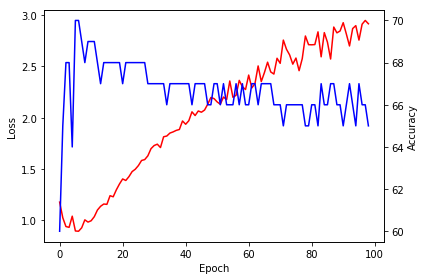

In [16]:
#plot

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(Epoch, Loss, color='red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(Epoch, Accuracy,color='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

